In [5]:
data_path = r"E:\Internship_Projects\Thyroid_Disease_Detection_ML\thyroid_detection\artifact\data_transformation\2025-03-21-06-05-22\transformed_data\train\train.npz"

In [2]:
import numpy as np
import os
import pandas as pd


In [6]:
X = np.load(data_path, allow_pickle=True)
print("X shape:", X.shape)

X shape: (6402, 37)


In [7]:
print("First 5 rows of X:\n", X[:5])  # Preview first 5 rows


First 5 rows of X:
 [[ 0.4425525   1.53380009 -0.16894122 -0.41242859  0.2741394  -0.73565356
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          1.          0.
   2.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          1.          0.
   1.          0.          1.          0.          1.          0.
   2.        ]
 [-1.23110288  0.05371022  0.16340115  0.76100105  0.          0.
   1.          0.          1.          0.          1.          0.
   1.          0. 

In [8]:
X_features = X[:, :-1]  # All columns except the last
y_labels = X[:, -1]  # Last column (assumed to be labels)

print("Features shape:", X_features.shape)
print("Labels shape:", y_labels.shape)


Features shape: (6402, 36)
Labels shape: (6402,)


In [9]:
# Convert features to DataFrame
df_X = pd.DataFrame(X_features)

# Convert labels to a Series
df_y = pd.Series(y_labels, name="Target")  

# Combine features and labels into one DataFrame
df = pd.concat([df_X, df_y], axis=1)

# Display the first few rows
print(df.head())

          0         1         2         3         4         5    6    7    8  \
0  0.442552  1.533800 -0.168941 -0.412429  0.274139 -0.735654  1.0  0.0  1.0   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.0  0.0  1.0   
2 -1.231103  0.053710  0.163401  0.761001  0.000000  0.000000  1.0  0.0  1.0   
3  0.487573 -0.349590  0.000000 -0.090453  0.328156 -0.392048  1.0  0.0  1.0   
4 -1.662205  2.749593  0.000000  0.029577  0.000000  0.000000  0.0  1.0  1.0   

     9  ...   27   28   29   30   31   32   33   34   35  Target  
0  0.0  ...  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0     2.0  
1  0.0  ...  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0     2.0  
2  0.0  ...  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0     2.0  
3  0.0  ...  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0     2.0  
4  0.0  ...  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0     2.0  

[5 rows x 37 columns]


In [11]:
print("null counts if present :", df.isnull().sum())

null counts if present : 0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
30        0
31        0
32        0
33        0
34        0
35        0
Target    0
dtype: int64


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count of each class in the target variable
class_counts = df["Target"].value_counts()
print(class_counts)

1.0    2134
0.0    2134
2.0    2134
Name: Target, dtype: int64


from imblearn.over_sampling import SMOTE
from collections import Counter

# Define features and target
X = df.iloc[:, :-1]  # Features
y = df["Target"]  # Target variable

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)  # Auto balances all classes
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print("After SMOTE:", Counter(y_resampled))


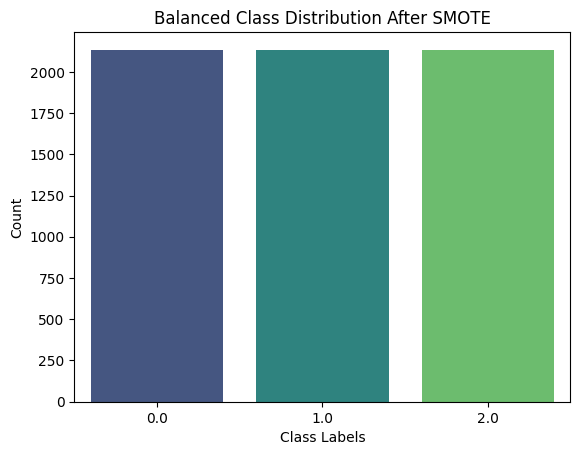

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df["Target"], palette="viridis")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Balanced Class Distribution After SMOTE")
plt.show()


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

print("Unique labels in y_train:", np.unique(y))

# Create a small test dataset
X, y = make_classification(n_samples=500, n_features=10, random_state=42)

# Define simple param grid
param_grid = {"n_estimators": [10, 50], "max_depth": [3, None]}

# Run GridSearchCV
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)
clf.fit(X, y)

print("Best Parameters:", clf.best_params_)


Unique labels in y_train: [0 1]
Fitting 3 folds for each of 4 candidates, totalling 12 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report, confusion_matrix






In [2]:
df1=pd.read_csv("processed_data.csv")

target_column= "Class"
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df1, df1[target_column]):
    train_set = df1.loc[train_index]
    test_set = df1.loc[test_index]

print("Train set class distribution:\n", train_set[target_column].value_counts(normalize=True))
print("\nTest set class distribution:\n", test_set[target_column].value_counts(normalize=True))

train_set.to_csv("train_data.csv", index=False)
test_set.to_csv("test_data.csv", index=False)

Train set class distribution:
 negative           0.952679
hyperthyroidism    0.044196
hypothyroidism     0.003125
Name: Class, dtype: float64

Test set class distribution:
 negative           0.951786
hyperthyroidism    0.044643
hypothyroidism     0.003571
Name: Class, dtype: float64


In [3]:
train_set = pd.read_csv("train_data.csv")
test_set = pd.read_csv("test_data.csv")
target_column = "Class"

In [4]:
X_train = train_set.drop(columns=[target_column])
y_train = train_set[target_column]
X_test = test_set.drop(columns=[target_column])
y_test = test_set[target_column]

In [6]:
y_train.unique()

array(['negative', 'hyperthyroidism', 'hypothyroidism'], dtype=object)

In [ ]:
X_train.isnull().sum()

In [ ]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns


num_transformer = SimpleImputer(strategy="median")
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)


# Apply transformations using ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# Fit and transform training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get new column names after encoding
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_cols = list(num_cols) + list(encoded_cat_cols)

# Convert transformed arrays into DataFrames
X_train = pd.DataFrame(X_train_transformed, columns=all_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_transformed, columns=all_cols, index=X_test.index)

print("Preprocessing complete! New shape of X_train:", X_train.shape)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
X_train.hist(bins=30)
plt.show()

In [ ]:
sns.boxplot(X_test["TT4"])
plt.show()

In [ ]:

# Log transform TSH to handle extreme skewness
X_train.loc[:, 'TSH'] = np.log1p(X_train['TSH'])
X_test.loc[:, 'TSH'] = np.log1p(X_test['TSH'])

# Choose scalers based on distribution
scalers = {
    'age': StandardScaler(),
    'TSH': RobustScaler(),   # After log transformation
    'TT4': RobustScaler(),
    'T4U': MinMaxScaler(),
    'FTI': MinMaxScaler(),
    'T3': RobustScaler()
}

# Apply appropriate scaling
for col, scaler in scalers.items():
    X_train[col] = scaler.fit_transform(X_train[[col]]).flatten()
    X_test[col] = scaler.transform(X_test[[col]]).flatten()


In [ ]:
#Check class distribution
print(y_train.value_counts())

In [ ]:
# Plot class distribution
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Data")
plt.show()

In [ ]:
minority_class = y_train.value_counts().min()
majority_class = y_train.value_counts().max()

imbalance_ratio = majority_class / minority_class
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")


In [ ]:
pip install imbalanced-learn


In [ ]:


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Check new class distribution
print(y_train_resampled.value_counts())

# Plot new class distribution
sns.countplot(x=y_train_resampled)
plt.title("Balanced Class Distribution (After Oversampling)")
plt.show()


In [ ]:
X_train_resampled.shape

In [ ]:
X_train_resampled=pd.DataFrame(data=X_train_resampled, columns=X_train.columns)

In [ ]:
X_train_resampled

In [ ]:
X_train_resampled.isnull().sum()

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

# Plot class distribution after SMOTE
sns.countplot(x=y_train_smote)
plt.title("Balanced Class Distribution (After SMOTE)")
plt.show()


 ##SMOTE vs. Random Oversampling

✔ Both techniques balance the dataset, but SMOTE is usually better as it generates synthetic data rather than duplicating samples.

✔ Random Oversampling might cause overfitting, as the model sees the same minority samples multiple times.

✔ SMOTE reduces overfitting risk by creating new synthetic points instead of copying existing ones.

Let's compare SMOTE vs. Random Oversampling by training a model on both resampled datasets and evaluating their performance.

 Steps to Compare


Train a classifier (e.g., Random Forest, Logistic Regression) on:

-Random Oversampling data 

-SMOTE data

Evaluate using:

-Accuracy

-Precision, Recall, F1-score

-Confusion Matrix

Compare results to see which technique performs better.

In [ ]:


# Initialize classifiers
model_ros = RandomForestClassifier(random_state=42)
model_smote = RandomForestClassifier(random_state=42)

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train models
model_ros.fit(X_train_ros, y_train_ros)
model_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_ros = model_ros.predict(X_test)
y_pred_smote = model_smote.predict(X_test)

# Evaluate Random Oversampling
print("=== Random Oversampling Results ===")
print(classification_report(y_test, y_pred_ros))
print("Confusion Matrix (Random Oversampling):")
sns.heatmap(confusion_matrix(y_test, y_pred_ros), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Oversampling")
plt.show()

# Evaluate SMOTE
print("=== SMOTE Results ===")
print(classification_report(y_test, y_pred_smote))
print("Confusion Matrix (SMOTE):")
sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - SMOTE")
plt.show()


In [ ]:


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Check new class distribution
print(y_train_resampled.value_counts())

# Plot new class distribution
sns.countplot(x=y_train_resampled)
plt.title("Balanced Class Distribution (After Oversampling)")
plt.show()


SMOTE improved recall for hyperthyroidism (from 72% to 80%) but at the cost of slightly reduced precision.

Hypothyroidism remains a challenge (recall stuck at 50%), meaning the model still struggles with extremely rare cases.

Negative class performance is slightly reduced but remains excellent.

Overall accuracy remains the same (98%), indicating SMOTE didn't drastically change the overall performance but helped with class balance.

1️⃣ we will Use SMOTE for Hypothyroidism + Random Oversampling for Hyperthyroidism
2️⃣ Experiment with XGBoost, Random Forest, and SVM

3️⃣ Evaluate results & fine-tune hyperparameters

In [ ]:
pip install imbalanced-learn xgboost scikit-learn


In [ ]:
X_train["TSH"].isnull().sum()

In [ ]:
# Identify numerical and categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Handle missing values
num_transformer = SimpleImputer(strategy="median")
cat_transformer =SimpleImputer(Strategy="most_frequent")
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_train[num_cols] = num_transformer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_transformer.transform(X_test[num_cols])

In [ ]:
X_train['TSH'].fillna(X_train['TSH'].median(), inplace=True)
X_test['TSH'].fillna(X_train['TSH'].median(), inplace=True)


In [ ]:
X_train["TSH"].isnull().sum()

In [ ]:
# Log transform TSH to handle extreme skewness
X_train.loc[:, 'TSH'] = np.log1p(X_train['TSH'])
X_test.loc[:, 'TSH'] = np.log1p(X_test['TSH'])

In [ ]:
X_train.isnull().sum()

In [ ]:


# Choose scalers based on distribution
scalers = {
    'age': StandardScaler(),
    'TSH': RobustScaler(),   # After log transformation
    'TT4': RobustScaler(),
    'T4U': MinMaxScaler(),
    'FTI': MinMaxScaler(),
    'T3': RobustScaler()
}

# Apply appropriate scaling
for col, scaler in scalers.items():
    X_train[col] = scaler.fit_transform(X_train[[col]]).flatten()
    X_test[col] = scaler.transform(X_test[[col]]).flatten()

# Final check before resampling
assert not X_train.isnull().values.any(), "X_train still contains NaN values!"
assert np.isfinite(X_train).all().all(), "X_train contains infinite values!"

# Reset indices to avoid misalignment issues
#y_train = y_train.reset_index(drop=True)
#X_train = X_train.reset_index(drop=True)



In [ ]:
X_train["TSH"].isnull().sum()

In [ ]:
# Apply SMOTE for hypothyroidism and Random Oversampling for hyperthyroidism
smote = SMOTE(sampling_strategy={"hypothyroidism": "auto"}, random_state=42)
ros = RandomOverSampler(sampling_strategy={"hyperthyroidism": "auto"}, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

# Convert back to DataFrame
X_train_balanced = pd.DataFrame(X_resampled, columns=X_train.columns)
y_train_balanced = pd.Series(y_resampled)


In [ ]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns


num_transformer = SimpleImputer(strategy="median")
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)


# Apply transformations using ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# Fit and transform training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get new column names after encoding
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_cols = list(num_cols) + list(encoded_cat_cols)

# Convert transformed arrays into DataFrames
X_train = pd.DataFrame(X_train_transformed, columns=all_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_transformed, columns=all_cols, index=X_test.index)

print("Preprocessing complete! New shape of X_train:", X_train.shape)

In [ ]:
X_train.isnull().sum()

In [ ]:


# Log transform TSH to handle extreme skewness
X_train.loc[:, 'TSH'] = np.log1p(X_train['TSH'])
X_test.loc[:, 'TSH'] = np.log1p(X_test['TSH'])

# Choose scalers based on distribution
scalers = {
    'age': StandardScaler(),
    'TSH': RobustScaler(),   # After log transformation
    'TT4': RobustScaler(),
    'T4U': MinMaxScaler(),
    'FTI': MinMaxScaler(),
    'T3': RobustScaler()
}

# Apply appropriate scaling
for col, scaler in scalers.items():
    X_train[col] = scaler.fit_transform(X_train[[col]]).flatten()
    X_test[col] = scaler.transform(X_test[[col]]).flatten()

# Combine features and target for resampling
y_train = y_train.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)

# Apply SMOTE for hypothyroidism and Random Oversampling for hyperthyroidism
smote = SMOTE(sampling_strategy={"hypothyroidism": "auto"}, random_state=42)
ros = RandomOverSampler(sampling_strategy={"hyperthyroidism": "auto"}, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

# Convert back to DataFrame
X_train_balanced = pd.DataFrame(X_resampled, columns=X_train.columns)
y_train_balanced = pd.Series(y_resampled)
